c:\Users\shah4\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


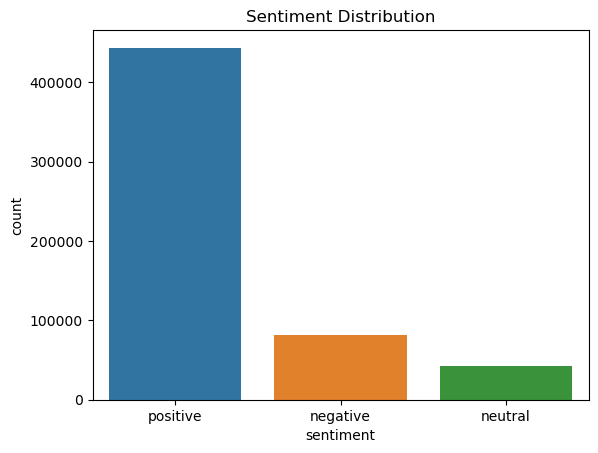

C:\Users\shah4\AppData\Local\Temp\ipykernel_46032\2055845870.py:34: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()       # remove HTML


Accuracy: 0.863480838412891
              precision    recall  f1-score   support

    negative       0.73      0.66      0.69     16407
     neutral       0.52      0.17      0.26      8528
    positive       0.89      0.97      0.93     88756

    accuracy                           0.86    113691
   macro avg       0.71      0.60      0.63    113691
weighted avg       0.84      0.86      0.84    113691



In [ ]:
import pandas as pd
import re
import string
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load dataset (adjust nrows as needed)
df = pd.read_csv("Reviews.csv")
df = df[['Score', 'Text']].dropna()

# Step 2: Label sentiment
def label_sentiment(score):
    if score in [4, 5]:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['Score'].apply(label_sentiment)

# Step 3: Explore class distribution
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

# Step 4: Use sklearn's built-in stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = ENGLISH_STOP_WORDS

# Step 5: Text cleaning
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()       # remove HTML
    text = text.lower()                                        # lowercase
    text = re.sub(r'\d+', '', text)                            # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = ' '.join(word for word in text.split() if word not in stop_words)  # remove stopwords
    return text

df['cleaned_text'] = df['Text'].apply(clean_text)

# Step 6: Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])  # 0 = negative, 1 = neutral, 2 = positive

# Step 7: Vectorization using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['label']

# Step 8: Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 9: Train Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Step 10: Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


# BERT Sentiment Classifier

We use the Hugging Face Transformers library, along with the cleaned and labeled data.

In [2]:
!pip install transformers datasets -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 1.8.1 requires huggingface_hub>=0.21.0, but you have huggingface-hub 0.16.4 which is incompatible.


In [3]:
from datasets import Dataset
import pandas as pd

# Optional: use a smaller sample to speed up training
df_small = df[['cleaned_text', 'label']].dropna().sample(10000, random_state=42)

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df_small)

In [19]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['cleaned_text'], truncation=True) #removed padding = true from func

tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [21]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

In [ ]:
%pip install transformers==4.31.0
%pip install accelerate==0.20.3
%pip install huggingface_hub==0.16.4

In [22]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
)

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_dataset['train'],
#     eval_dataset=tokenized_dataset['test'],
# )
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    data_collator=data_collator  # ✅ THIS LINE FIXES THE ERROR
)

In [24]:
trainer.train()

  0%|          | 0/2000 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.7439, 'learning_rate': 4.975e-05, 'epoch': 0.01}
{'loss': 0.8527, 'learning_rate': 4.9500000000000004e-05, 'epoch': 0.02}
{'loss': 0.6825, 'learning_rate': 4.9250000000000004e-05, 'epoch': 0.03}
{'loss': 0.7377, 'learning_rate': 4.9e-05, 'epoch': 0.04}
{'loss': 0.7137, 'learning_rate': 4.875e-05, 'epoch': 0.05}
{'loss': 0.6722, 'learning_rate': 4.85e-05, 'epoch': 0.06}
{'loss': 0.6892, 'learning_rate': 4.825e-05, 'epoch': 0.07}
{'loss': 0.695, 'learning_rate': 4.8e-05, 'epoch': 0.08}
{'loss': 0.5834, 'learning_rate': 4.775e-05, 'epoch': 0.09}
{'loss': 0.6365, 'learning_rate': 4.75e-05, 'epoch': 0.1}
{'loss': 0.4702, 'learning_rate': 4.7249999999999997e-05, 'epoch': 0.11}
{'loss': 0.8045, 'learning_rate': 4.7e-05, 'epoch': 0.12}
{'loss': 0.4756, 'learning_rate': 4.6750000000000005e-05, 'epoch': 0.13}
{'loss': 0.7267, 'learning_rate': 4.6500000000000005e-05, 'epoch': 0.14}
{'loss': 0.5332, 'learning_rate': 4.6250000000000006e-05, 'epoch': 0.15}
{'loss': 0.505, 'learning_rate':

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.5628081560134888, 'eval_runtime': 194.0226, 'eval_samples_per_second': 10.308, 'eval_steps_per_second': 1.289, 'epoch': 1.0}
{'loss': 0.7753, 'learning_rate': 2.4750000000000002e-05, 'epoch': 1.01}
{'loss': 0.3256, 'learning_rate': 2.45e-05, 'epoch': 1.02}
{'loss': 0.4316, 'learning_rate': 2.425e-05, 'epoch': 1.03}
{'loss': 0.4293, 'learning_rate': 2.4e-05, 'epoch': 1.04}
{'loss': 0.401, 'learning_rate': 2.375e-05, 'epoch': 1.05}
{'loss': 0.3017, 'learning_rate': 2.35e-05, 'epoch': 1.06}
{'loss': 0.1825, 'learning_rate': 2.3250000000000003e-05, 'epoch': 1.07}
{'loss': 0.5787, 'learning_rate': 2.3000000000000003e-05, 'epoch': 1.08}
{'loss': 0.6064, 'learning_rate': 2.275e-05, 'epoch': 1.09}
{'loss': 0.367, 'learning_rate': 2.25e-05, 'epoch': 1.1}
{'loss': 0.4881, 'learning_rate': 2.2250000000000002e-05, 'epoch': 1.11}
{'loss': 0.3178, 'learning_rate': 2.2000000000000003e-05, 'epoch': 1.12}
{'loss': 0.4387, 'learning_rate': 2.175e-05, 'epoch': 1.13}
{'loss': 0.5514, 'lear

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.506239116191864, 'eval_runtime': 187.8193, 'eval_samples_per_second': 10.649, 'eval_steps_per_second': 1.331, 'epoch': 2.0}
{'train_runtime': 8965.719, 'train_samples_per_second': 1.785, 'train_steps_per_second': 0.223, 'train_loss': 0.4775597867369652, 'epoch': 2.0}


TrainOutput(global_step=2000, training_loss=0.4775597867369652, metrics={'train_runtime': 8965.719, 'train_samples_per_second': 1.785, 'train_steps_per_second': 0.223, 'train_loss': 0.4775597867369652, 'epoch': 2.0})

In [25]:
trainer.evaluate()

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.506239116191864,
 'eval_runtime': 332.0361,
 'eval_samples_per_second': 6.023,
 'eval_steps_per_second': 0.753,
 'epoch': 2.0}

In [30]:
test_dataset = tokenized_dataset["test"]

In [31]:
predictions = trainer.predict(test_dataset)

  0%|          | 0/250 [00:00<?, ?it/s]

In [32]:
from sklearn.metrics import classification_report

y_true = test_dataset['label']
y_pred = predictions.predictions.argmax(axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.52      0.61       285
           1       0.17      0.06      0.09       139
           2       0.87      0.97      0.92      1576

    accuracy                           0.84      2000
   macro avg       0.60      0.52      0.54      2000
weighted avg       0.81      0.84      0.82      2000



In [33]:
trainer.save_model("fine-tuned-bert-amazon")
tokenizer.save_pretrained("fine-tuned-bert-amazon")

('fine-tuned-bert-amazon\\tokenizer_config.json',
 'fine-tuned-bert-amazon\\special_tokens_map.json',
 'fine-tuned-bert-amazon\\vocab.txt',
 'fine-tuned-bert-amazon\\added_tokens.json',
 'fine-tuned-bert-amazon\\tokenizer.json')